In [12]:
#Imports
import numpy as np
from astropy.table import Table
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d 
import os
import time
from tqdm import tqdm
%matplotlib inline

In [13]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"

tmplt_data_path = os.path.join(dataset_dir,"UPDATED_TEMPELATE_SPECTRA.fits")
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")

spec_data = Table.read(spec_data_path)
tmplt_data = Table.read(tmplt_data_path)

In [14]:
observed_specs = np.array(spec_data["spec_norm"])
observed_wavelengths = np.linspace(3500,5500,len(observed_specs[0]))

norm_tmplt_specs = np.array(tmplt_data["norm_specs"])

In [15]:
def chi_sq(observed_spectra,norm_tmplt_specs,err):
    min_score = np.inf
    min_idx = None
    scores = []
    for i,refit_tmplt_spec in enumerate(norm_tmplt_specs):
        numerator = (observed_spectra-refit_tmplt_spec)**2
        denominator = np.sqrt(err)
        chi_sq_score = np.sum(numerator/denominator)
        scores.append(chi_sq_score)
        if chi_sq_score < min_score:
            min_score = chi_sq_score
            min_idx = i
    
    return min_idx

min_score_idx = []
counter = 0

for observed_spec in tqdm(observed_specs):
    err = np.array(spec_data["updated_var"][counter])
    idx = chi_sq(observed_spec,norm_tmplt_specs,err)
    min_score_idx.append(idx)
    counter += 1

min_score_idx = np.array(min_score_idx)
len(set(min_score_idx))

#plot of chi sq dist
#plot the spectra (w/error) and max/min chi2 template


100%|██████████| 1403/1403 [00:11<00:00, 120.58it/s]


129

In [16]:
errs = np.array(spec_data["updated_var"])
counter = 0
for obj in errs:
    if True in np.isnan(obj):
        counter += 1
counter

0

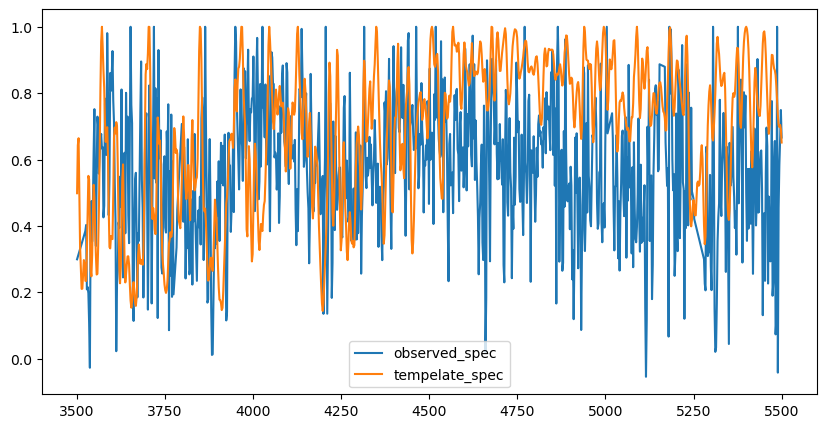

In [17]:
obs_wav = np.linspace(3500,5500,936)
plt.figure(figsize=(10,5))
ex_idx = 1401

plt.plot(obs_wav,observed_specs[ex_idx],label="observed_spec")
plt.plot(obs_wav,norm_tmplt_specs[min_score_idx[ex_idx]],label="tempelate_spec")
plt.legend()

In [ ]:
"""
#Faster CCF using dot products

c = 299792.46 #c in km/s
iters = 10

def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    #g = interp1d(new_wavelengths,tmplt_spec,fill_value="extrapolate",kind="linear",bounds_error=False)
    test_cs = CubicSpline(new_wavelengths,tmplt_spec)

    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec,high_range):
    start = time.perf_counter()
    negative = False
    negative_rv_score = get_score(-0.5,tmplt_spec,observed_spec,observed_wavelengths)
    positive_rv_score = get_score(0.5,tmplt_spec,observed_spec,observed_wavelengths)

    if negative_rv_score > positive_rv_score:
        high = -high_range
        negative = True

    elif positive_rv_score > negative_rv_score:
        high = high_range

    low = 0
    mid = (low + high)/2

    counter = 0
    predicted_rv = None

    while counter <= iters:

        if not negative:
            mid_plus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
        else:
            mid_plus_score = get_score(mid-1,tmplt_spec,observed_spec,observed_wavelengths)
            mid_minus_score = get_score(mid+1,tmplt_spec,observed_spec,observed_wavelengths)

        score_delta = mid_plus_score - mid_minus_score

        if score_delta < 0:
            high = mid
            mid = (low + high)/2

        elif score_delta > 0:
            low = mid
            mid = (low + high)/2
        
        predicted_rv = mid
        counter += 1
        
    finish = time.perf_counter()
    
    return predicted_rv


predicted_rvs = []
timings = []
counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,tmplt_specs[best_tmplt_idx],600.5)   )
    counter += 1
"""

In [ ]:
"""
#Slower CCF using dot products
c = 299792.46
predicted_rvs = []
def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const

    test_cs = CubicSpline(new_wavelengths,tmplt_spec)
    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec):
    start = time.perf_counter()
    value_range = np.arange(-1000,1000,0.5)

    scores = []
    for rv in value_range:
        current_score = get_score(rv,tmplt_spec,observed_spec,observed_wavelengths)
        scores.append(current_score)
    predicted_rv = value_range[np.argmax(scores)]
    return predicted_rv

counter = 0
for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rvs.append(   ccf(observed_spec,observed_wavelengths,norm_tmplt_specs[best_tmplt_idx])  )
    counter += 1
"""

In [18]:
#Slower CCF using dot products
c = 299792.46
def get_score(v,tmplt_spec,observed_spec,observed_wavelengths):
    
    tmplt_shift_const = (v+c)/c #formula (2)
    new_wavelengths = observed_wavelengths * tmplt_shift_const
    test_cs = CubicSpline(new_wavelengths,tmplt_spec)
    interpolated_tmplt_spec = np.array(test_cs(observed_wavelengths))
    return np.dot(interpolated_tmplt_spec,observed_spec)

def ccf(observed_spec,observed_wavelengths,tmplt_spec):

    value_range = np.arange(-600,600,2)

    scores = []
    for rv in value_range:
        current_score = get_score(rv,tmplt_spec,observed_spec,observed_wavelengths)
        scores.append(current_score)
    predicted_rv = value_range[np.argmax(scores)]

    return predicted_rv,scores

counter = 0
predicted_rvs = []
scores = []

for observed_spec in tqdm(observed_specs[:100]):
    best_tmplt_idx = min_score_idx[counter]
    predicted_rv, score_arr =  ccf(observed_spec,observed_wavelengths,norm_tmplt_specs[best_tmplt_idx])
    predicted_rvs.append(predicted_rv)
    scores.append(score_arr)
    counter += 1

100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


In [19]:
unique, counts = np.unique(predicted_rvs, return_counts=True)
d = dict(zip(unique, counts))
d[598]

35

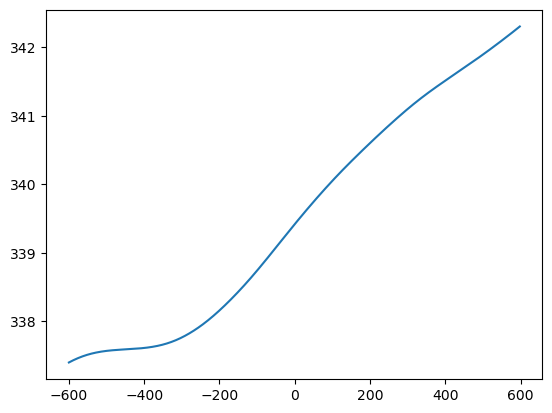

In [20]:
plt.plot(np.arange(-600,600,2),scores[88])

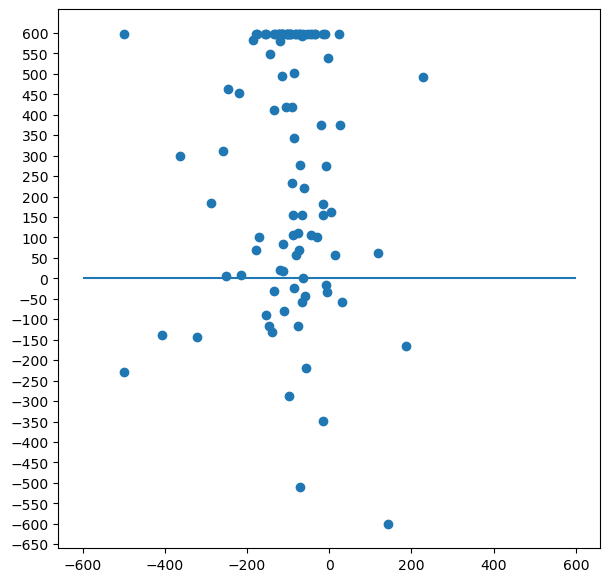

In [60]:
delta_RV = np.array(predicted_rvs) - spec_data["RV_1"][:100]
plt.figure(figsize=(7,7))
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.scatter(spec_data["RV_1"][:100],predicted_rvs)

In [61]:
np.mean(delta_RV),np.std(delta_RV)

(385.42365258710345, 334.9602187466674)